#**미니 배치 경사 하강법**

딥러닝에서 데이터가 아주 많은 경우 배치 경사 하강법을 사용하기 어렵다.   
실전에서는 확률적 경사 하강법과 배치 경사 하강법의 장점을 절충한   
**'미니 배치 경사 하강법'**을 널리 사용한다.
<br>

미니 배치 경사 하강법은 배치 경사 하강법과 유사하지만 매 에포크마다 전체 데이터를 사용하는 것이 아닌,   
데이터를 조금씩 나누어 정방향 계산을 수행하고 그레이디언트를 구하여 가중치를 업데이트한다.  
배치 크기는 보통 16, 32, 64 등 2의 배수를 사용한다.

In [ ]:
# import dependencies

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


# divid samples into train, val, test sets

cancer = load_breast_cancer()
c_data = cancer.data
c_target = cancer.target
train_data_all, test_data, train_target_all, test_target = train_test_split(c_data, c_target, stratify=c_target, test_size=0.2, random_state=42)
train_data, val_data, train_target, val_target = train_test_split(train_data_all, train_target_all, stratify=train_target_all, test_size=0.2, random_state=42)
print(train_data.shape, val_data.shape)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_data)  # train_data를 넣어 fit()하여 변환 규칙을 익히고
train_data_scaled = scaler.transform(train_data)  # 표준화 전처리
val_data_scaled = scaler.transform(val_data)


class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None   # 입력데이터의 특성이 많아 가중치와 절편을 미리 초기화하지 않는다.
    self.b = None   # 나중에 입력데이터를 보고 특성 개수에 맞게 결정
    self.losses = []
    self.w_history = []   # 가중치를 저장할 리스트
    self.lr = learning_rate   # 학습률 
    self.val_losses = []    # 검증세트 손실을 기록할 리스트
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z = np.dot(x, self.w) + self.b   # x=(364, 30) dot w=(30, 1) = z=(364, 1)
    return z


  def backprop(self, x, err):   # 오차역전파 메서드
    m = len(x)
    w_grad = np.dot(x.T, err) / m # x.T=(364, 30) dot err=(30, 1) = w_grad=(364, 1)
    b_grad = np.sum(err) / m  # err/m = (364, 1)
    return w_grad, b_grad


  def fit(self, x, y, epochs=100, x_val=None, y_val=None):  # 검증세트를 전달받을 x_val, y_val 추가
    y = y.reshape(-1, 1)  # 타깃을 열벡터로 바꾼다.
    y_val = y_val.reshape(-1, 1)  # 검증타깃을 열벡터로 바꾼다.
    m = len(x)
    self.w = np.ones((x.shape[1], 1))  # 가중치와 절편 초기화
    self.b = 0
    self.w_history.append(self.w.copy())  # 가중치 기록 -> 넘파이 배열(w)을 추가하면 실제값이 추가되는 것이 아닌 배열을 참조하기 때문에 w값이 바뀌면 그 값을 복사하여 추가해주어야 한다.
    np.random.seed(42)
    for i in range(epochs):
      z = self.forpass(x)   # 정방향 계산
      a = self.activation(z)  # 정방향 계산의 결과값인 z를 활성화 함수에 통과
      err =  -(y - a)       # 활성화 함수를 거친 a값으로 오차량 계산
      w_grad, b_grad = self.backprop(x, err)  # 오차역전파
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m # 그레이디언트에서 패널티 항의 미분값을 더한다.
      self.w -= self.lr * w_grad   # 그레이디언트 업데이트  (학습률 적용)
      self.b -= self.lr * b_grad
      self.w_history.append(self.w.copy())  # 가중치 기록
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))  # 로지스틱 손실함수 -(ylog(a) - (1 - y)log(1 - a))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)  # 검증세트 손실을 업데이트하는 메서드 호출


  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))


  def activation(self, z):  # 활성화 함수
    z = np.clip(z, -100, None)    # 안전한 계산을 위해 클리핑
    a = 1 / (1 + np.exp(-z))
    return a


  def predict(self, x): # 예측 함수
    z = self.forpass(x)
    return z > 0  # 계단함수


  def score(self, x, y):    # 평가함수
    return np.mean(self.predict(x) == y.reshape(-1, 1))


class DualLayer(SingleLayer):

  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
    self.units = units  # 은닉층 유닛 개수
    self.w1 = None      # 은닉층의 가중치
    self.b1 = None      # 은닉층의 절편
    self.w2 = None      # 출력층의 가중치
    self.b2 = None      # 출력층의 절편
    self.a1 = None      # 은닉층의 활성화 출력
    self.losses = []    # 훈련 손실
    self.val_losses = []  # 검증 손실
    self.lr = learning_rate # 학습률
    self.l1 = l1    # L1 손실 파라미터
    self.l2 = l2    # L2 손실 파라미터

  
  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.activation(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2

  
  def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m  # 출력층 그레이디언트
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)  # 시그모이드 함수까지 그레이디언트 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad


  def init_weights(self, n_features):
    self.w1 = np.ones((n_features, self.units))   # 가중치 행렬 초기화 (특성개수, 뉴런 개수(은닉층 크기))
    self.b1 = np.zeros(self.units)  # 뉴런 개수(은닉층 크기)
    self.w2 = np.ones((self.units, 1))  # (뉴런 개수(은닉층 크기), 1)
    self.b2 = 0

  
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    m = len(x)
    self.init_weights(x.shape[1])
    for i in range(epochs):
      a = self.training(x, y, m)
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)

  
  def training(self, x, y, m):
    z = self.forpass(x)
    a = self.activation(z)
    err = -(y - a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a


  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
            self.l2 / 2 *(np.sum(self.w1**2) + np.sum(self.w2**2))


class RandomInitNetwork(DualLayer):

  def init_weights(self, n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0, 1, (n_features, self.units))  # np.random.normal(평균, 표준편차, 배열크기)
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1, (self.units, 1))
    self.b2 = 0

(364, 30) (91, 30)


#**MiniBatchNetwork 클래스 구현**
RandomInitNetwork 클래스를 상속하여 구현해보자.

In [ ]:
class MiniBatchNetwork(RandomInitNetwork):

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    super().__init__(units, learning_rate, l1, l2)
    self.batch_size = batch_size

  
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y_val = y_val.reshape(-1, 1)
    self.init_weights(x.shape[1])
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      for x_batch, y_batch in self.gen_batch(x, y):
        y_batch = y_batch.reshape(-1, 1)
        m = len(x_batch)
        a = self.training(x_batch, y_batch, m)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += np.sum(-(y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a)))
      self.losses.append((loss + self.reg_loss()) / len(x))
      self.update_val_loss(x_val, y_val)


  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size:
      bins += 1
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]

In [ ]:
minibatch_net = MiniBatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(train_data_scaled, train_target, x_val=val_data_scaled, y_val=val_target, epochs=500)
minibatch_net.score(val_data_scaled, val_target)

0.978021978021978

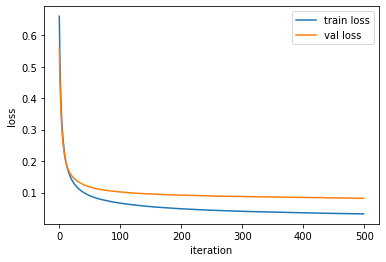

In [ ]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train loss', 'val loss'])
plt.show()

#**사이킷런을 이용해 다층 신경망 훈련**

sklearn.neural_network 모듈 아래에 분류작업을 위한 MLPClassifier,   
회귀작업을 위한 MLPRegressor를 제공한다.   
cancer 데이터셋에 MLPClassifier를 적용해보자.

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, ), activation='logistic', solver='sgd', alpha=0.01, batch_size=32, learning_rate_init=0.1, max_iter=500)

In [ ]:
mlp.fit(train_data_scaled, train_target)
mlp.score(val_data_scaled, val_target)

0.989010989010989